In [1]:
"""
    Package Installation
"""
__author__ = "SakibApon"
__email__ = "sakibapon7@gmail.com"

import os
import pywt
import numpy as np
import pandas as pd
from numpy import argmax
import matplotlib.pyplot as plt
from pandas import DataFrame

import graphviz
import xgboost as xgb
from xgboost import plot_tree
from scipy import signal

import sklearn
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve

In [2]:
data = pd.read_csv('../input/bledataset/BLE_rssi_after_FFT_Filter_Grid_1.5m_1.25m.csv')

data = data.drop(['date'],axis=1)

#Performance List
l = []

"""Instructions:
In following we will apply wavelet transformationm. The transformation is a two dimential matix. I took first column as a transformed data.
That provides better result. I then do it for multi times. That is, every time, I took first column of the transformed data,
And then I re-apply wavelet on the extracted column data. How many times do we want to perform that wavelet transform, that I controlled by t."""

t = 3
widths = np.arange(1, len(data)+1)

for k in range(1,t):
    for i in range(1,6):
        cwtmatr = signal.cwt(data.iloc[:,i], signal.ricker, widths)
        (cA, cD) = pywt.dwt([1,2,3,4,5,6], 'db1')

        cwtmatr=cwtmatr.astype(int)
        data.iloc[:,i]=cwtmatr[:,0]

X = data.iloc[:,1:]
y = data.iloc[:,0]

#Encoder
le = LabelEncoder()
y = le.fit_transform(y)

trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [3]:
xgb_classifier = xgb.XGBClassifier(max_depth = 5, learning_rate = 0.2, n_estimators = 300, objective='multi:softprob', booster='gbtree',  min_child_weight  =  6)
xgb_classifier.fit(trainX, trainY)

"""plot_tree(xgb_classifier,  num_trees=4)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')
plt.show()"""

predY_XGB = xgb_classifier.predict(testX)

modelName = "XGB"
accuracy = round(accuracy_score(testY, predY_XGB),4)*100 
accuracy

97.57000000000001

In [4]:
testX.reset_index(drop=True, inplace=True)
testX.head()

beacon1  beacon2  beacon3  beacon4  beacon5
0   -21328   -16566   -18703   -23893   -20881
1   -16851   -12564   -14330   -18805   -16558
2    13347    13204    13921    15450    12352
3     7556     8398     8663     8879     6878
4   -23105   -18256   -20529   -25925   -22590

In [5]:
testY

array([65, 83, 44, ..., 29, 81, 15])

# Shapely

In [6]:
import shap
explainer = shap.TreeExplainer(xgb_classifier)

In [7]:
# Calculate Shap values
choosen_instance = testX.loc[[0]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


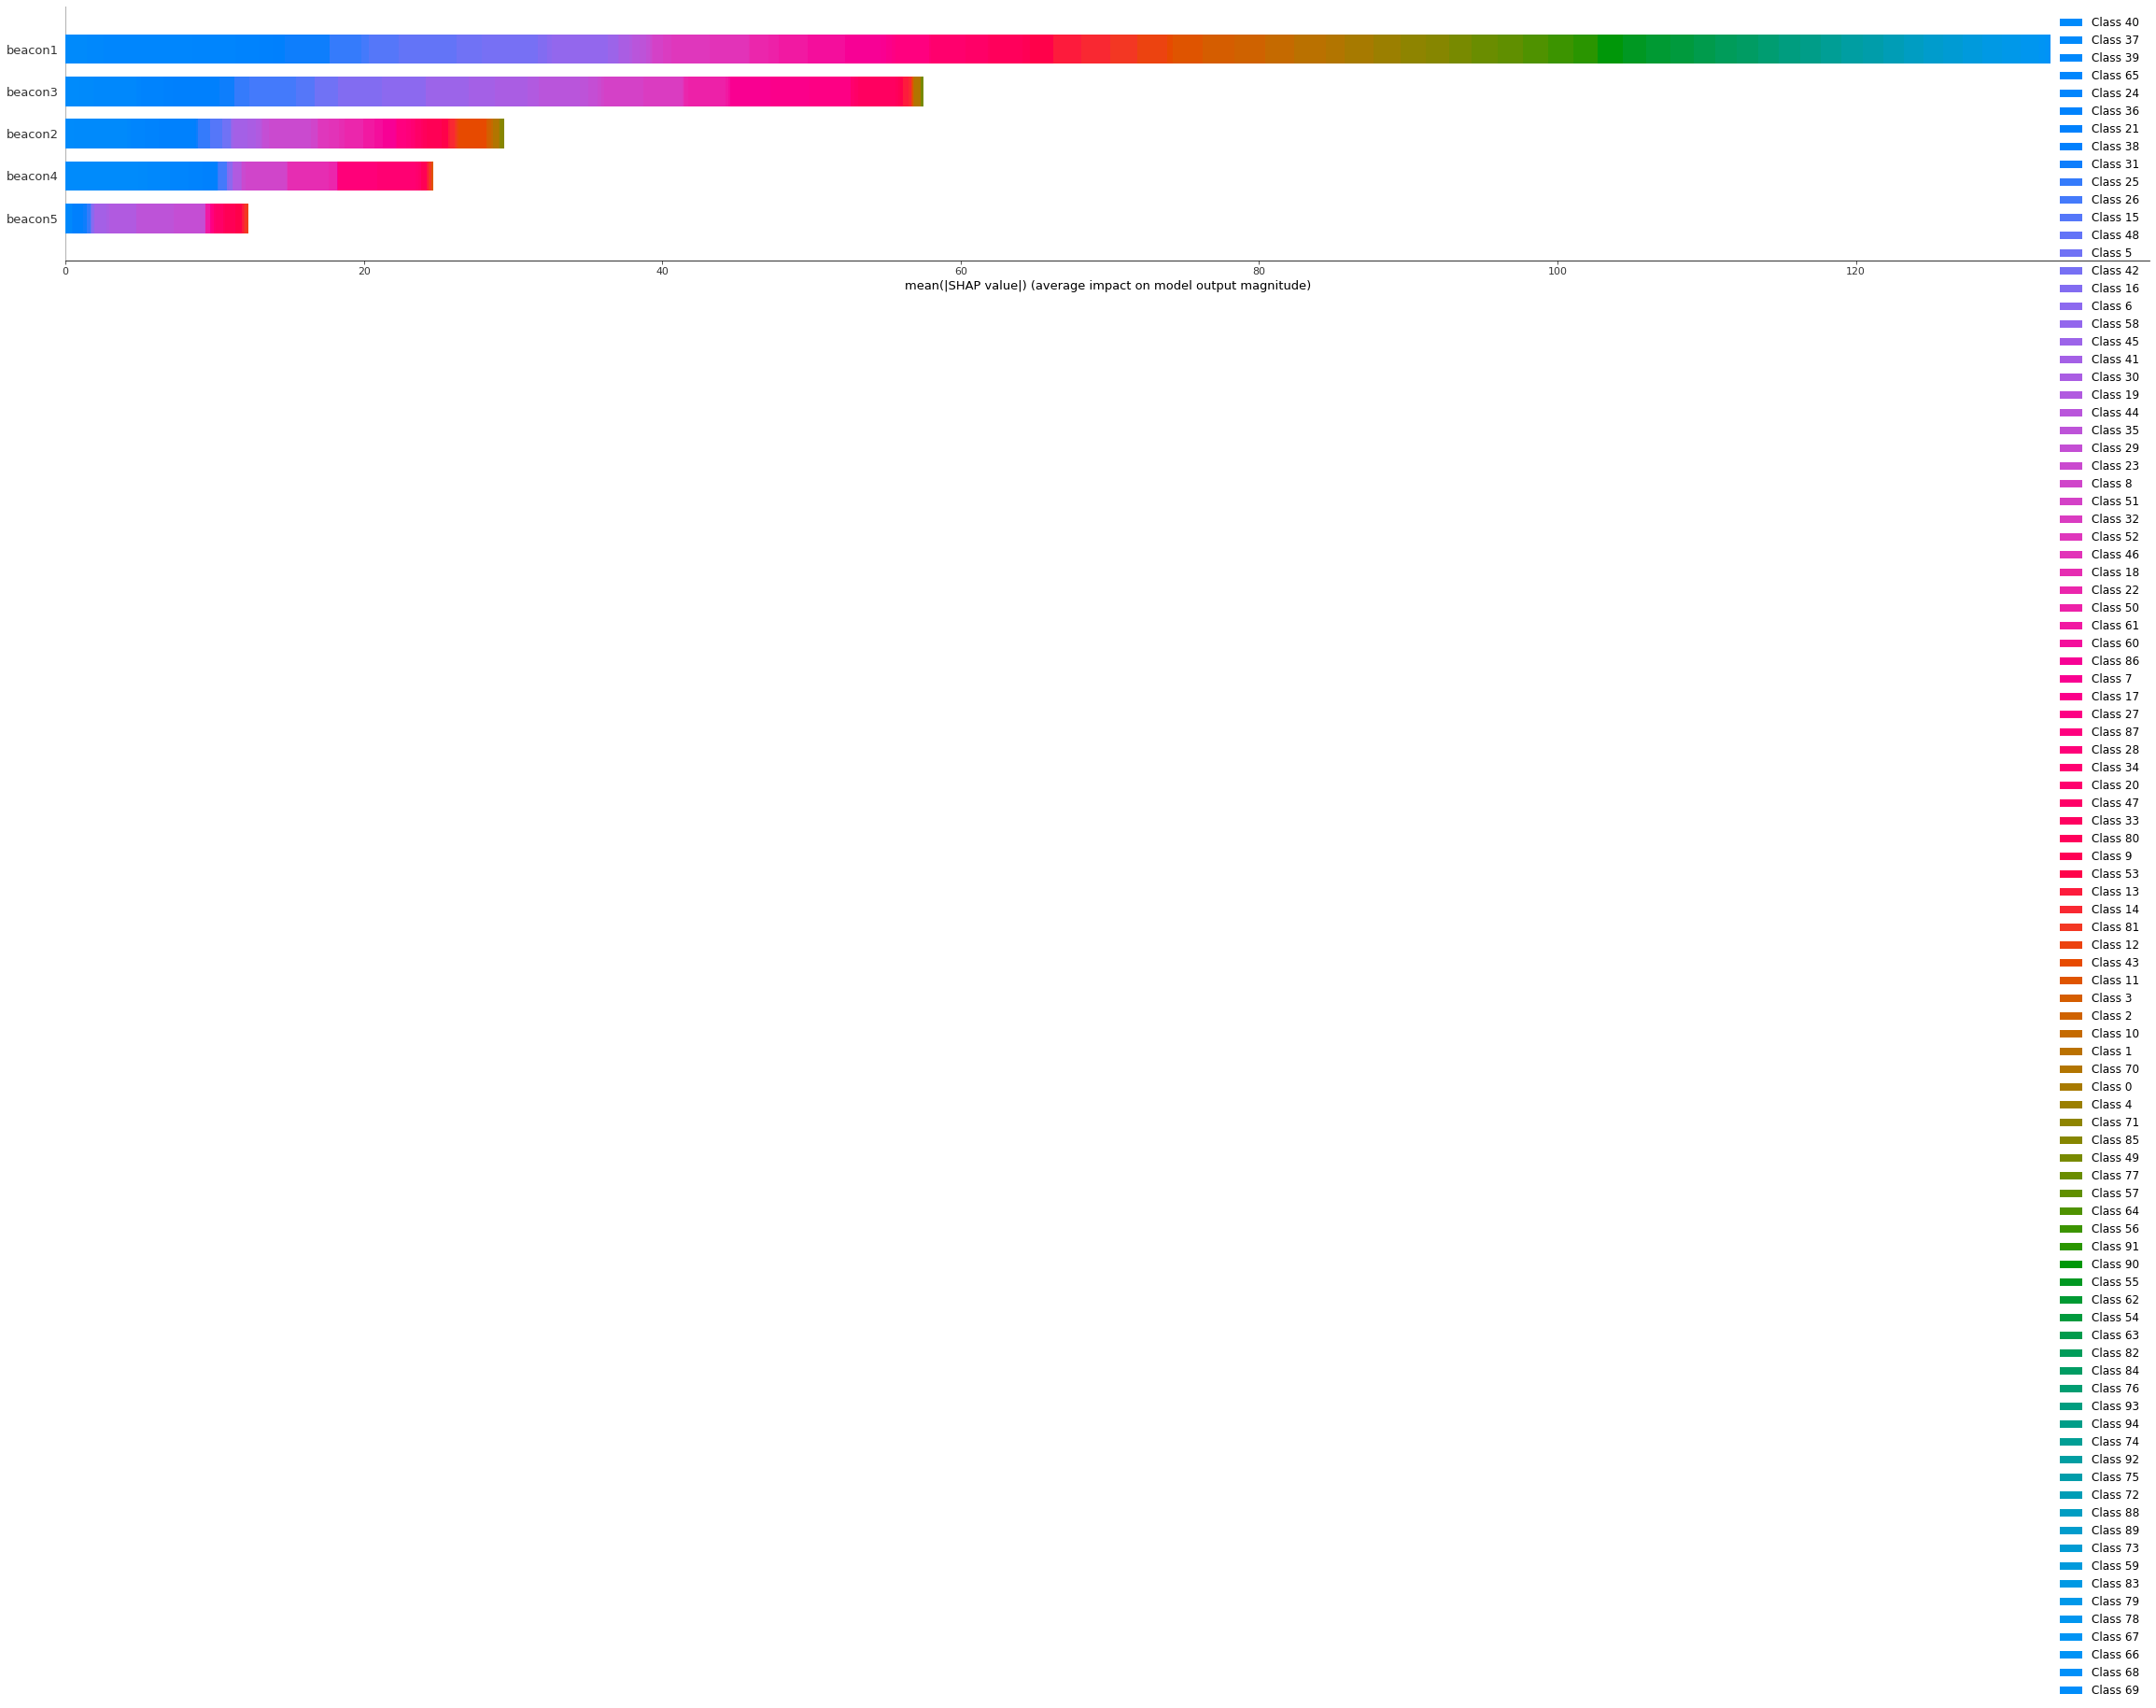

In [8]:
shap.summary_plot(shap_values, trainX,  plot_size=[40,5])

In [9]:
indexing = 1
# Calculate Shap values
choosen_instance = testX.loc[[indexing]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

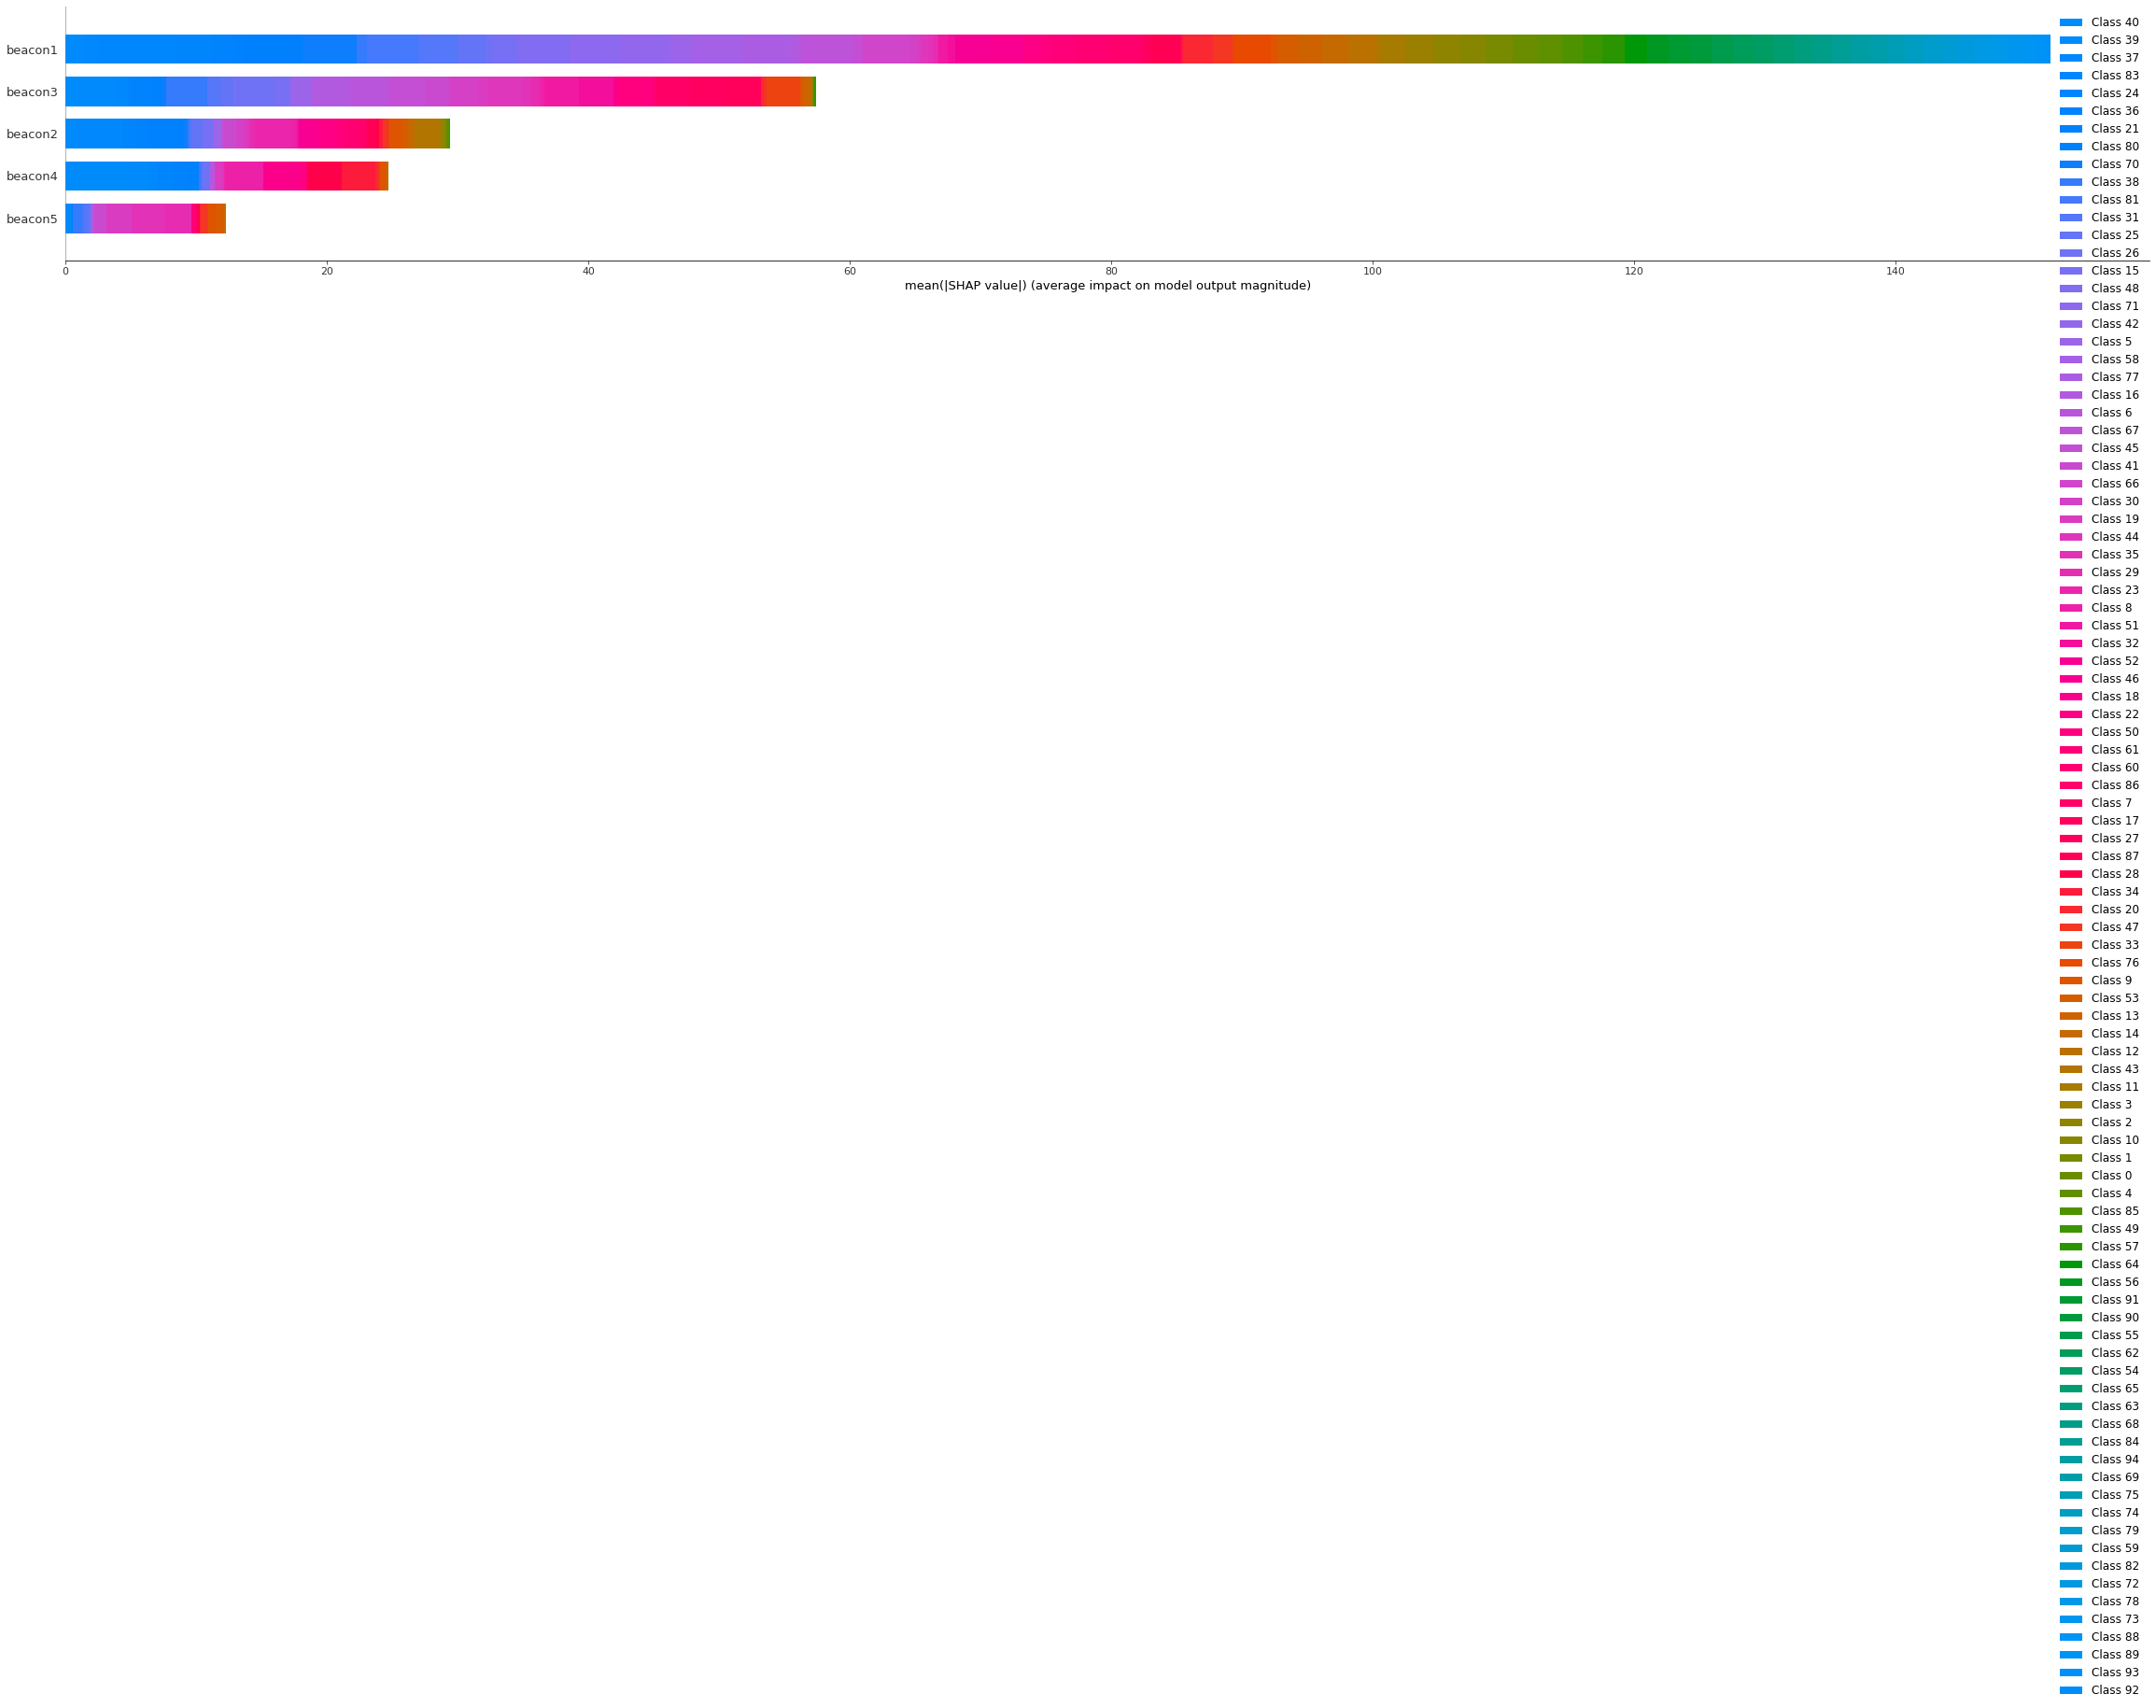

In [10]:
shap.summary_plot(shap_values, trainX,  plot_size=[40,5])

In [11]:
# Calculate Shap values
indexing = 2
choosen_instance = testX.loc[[indexing]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

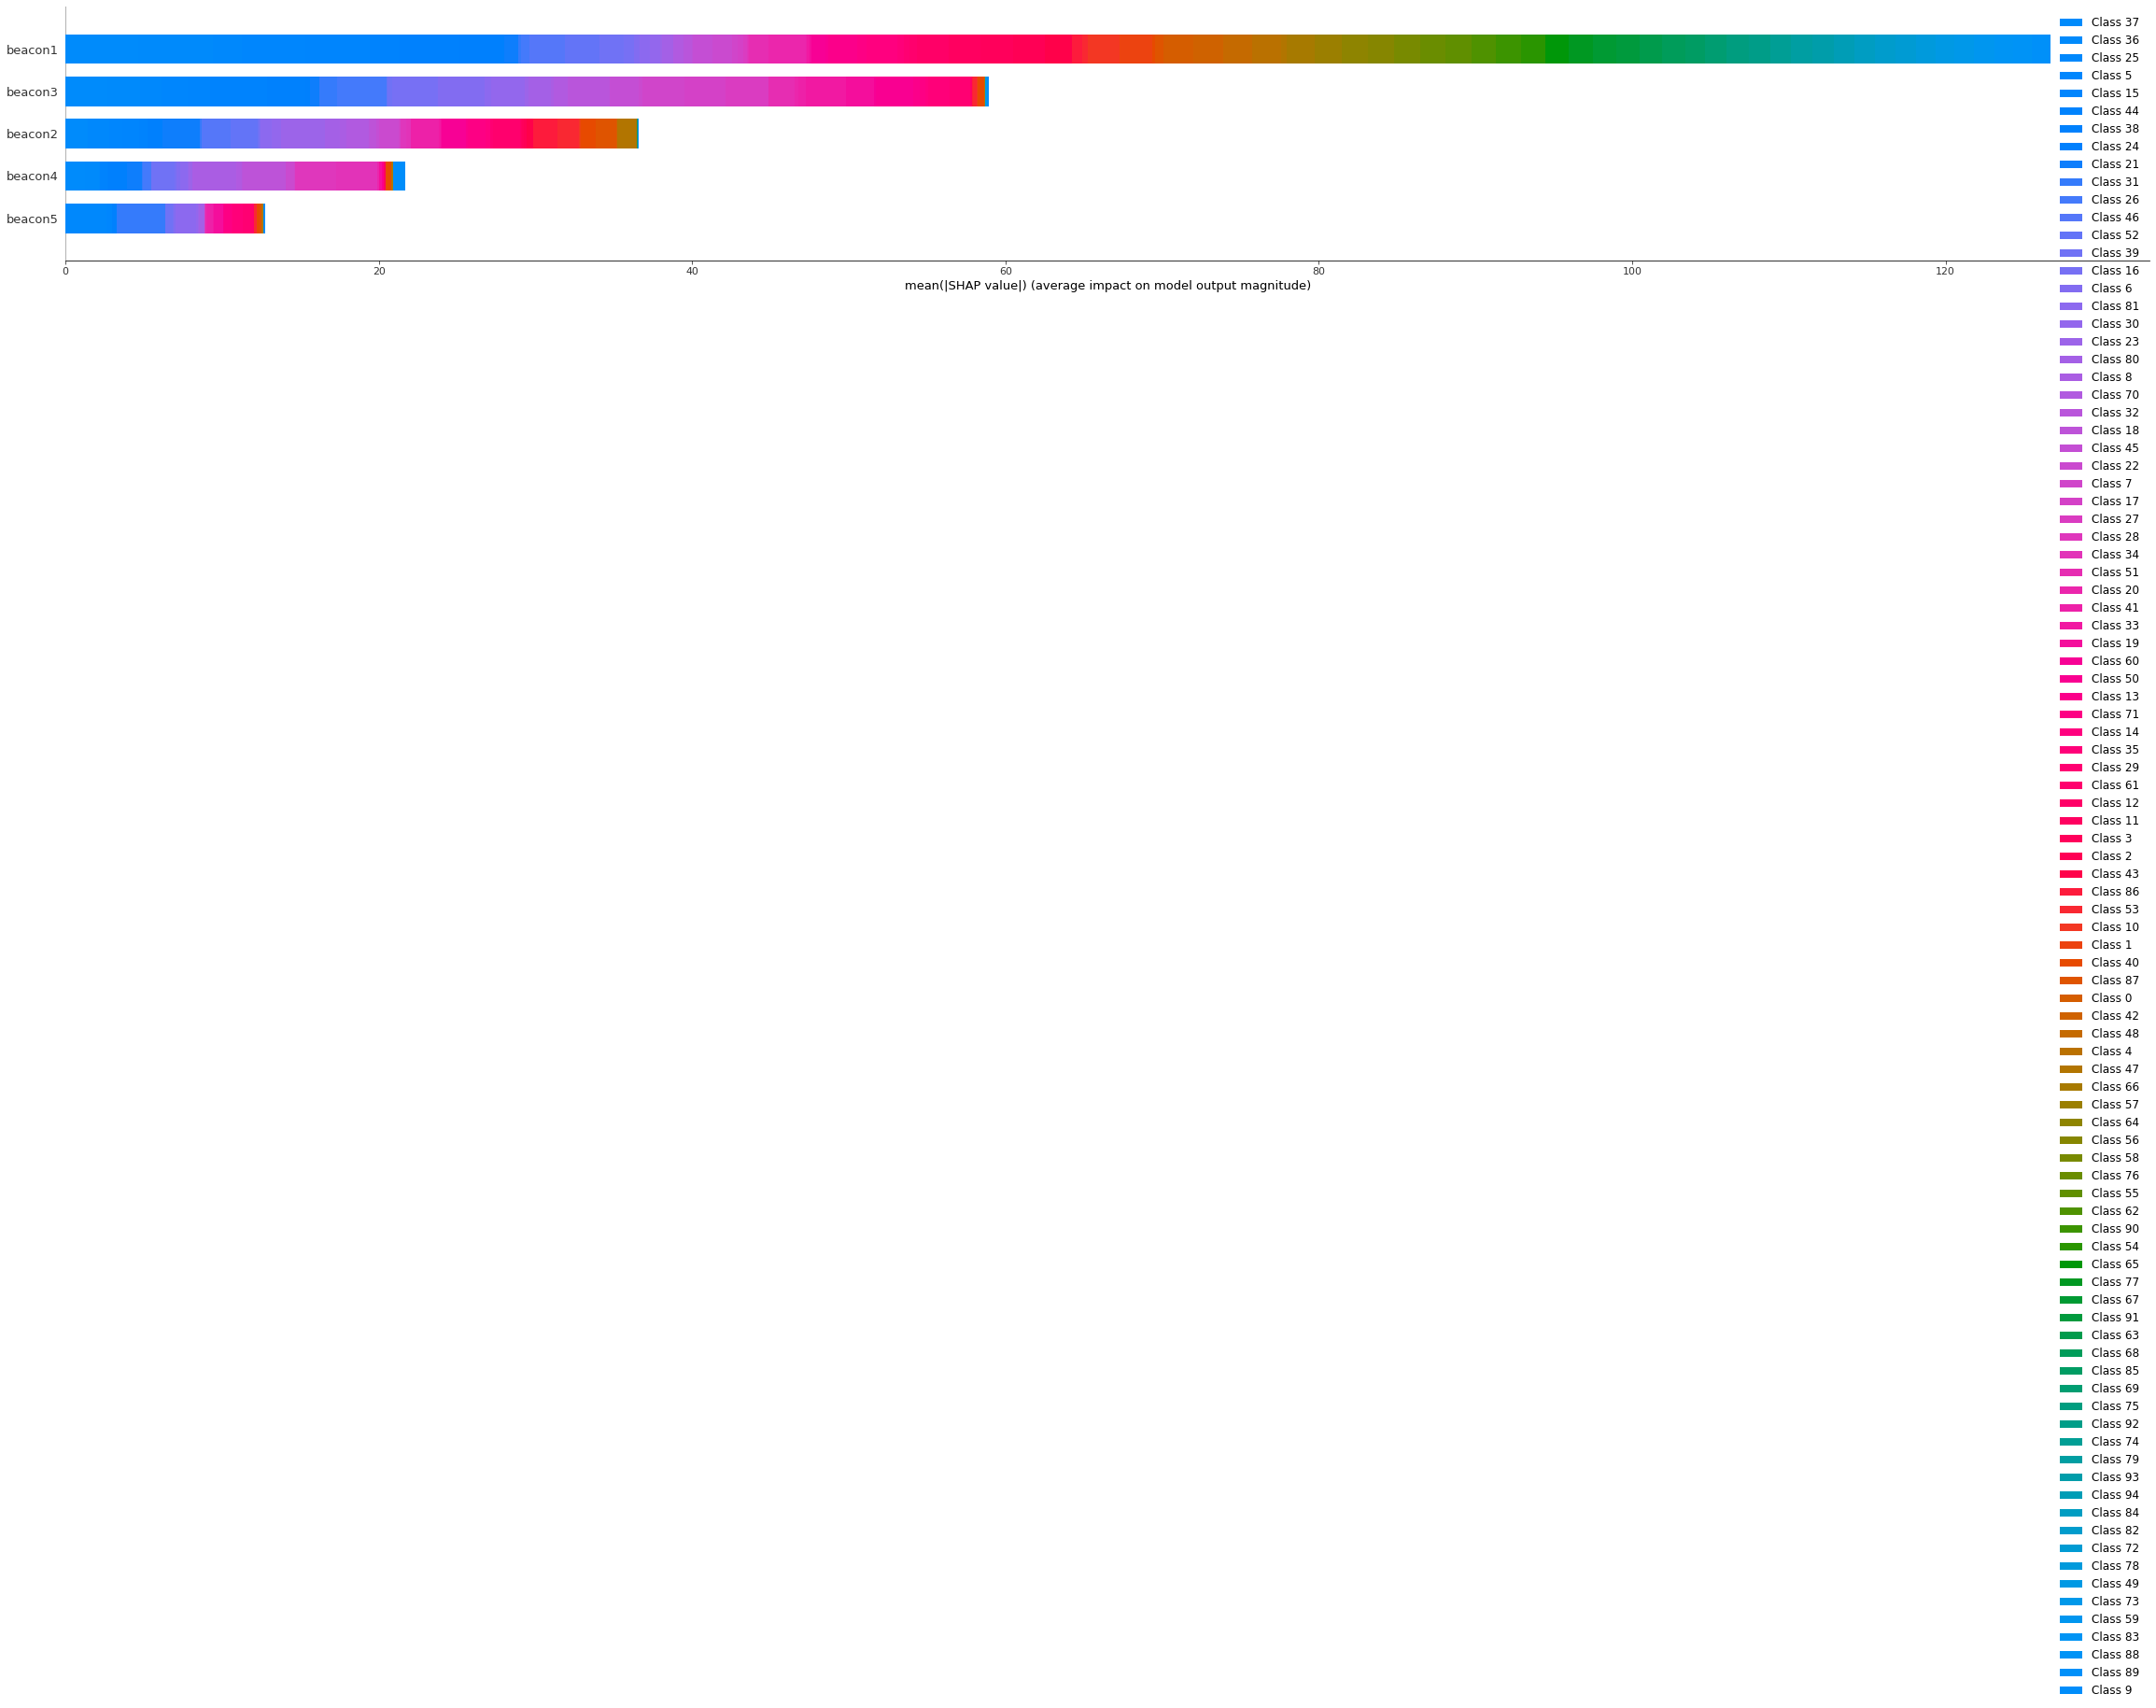

In [12]:
shap.summary_plot(shap_values, trainX,  plot_size=[40,5])

# LIME

In [14]:
import lime
import lime.lime_tabular

In [15]:
predict_fn_rf = lambda x: xgb_classifier.predict_proba(x).astype(float)
X = trainX.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = trainX.columns,kernel_width=5)

In [16]:
choosen_instance = testX.loc[[0]].values[0]
print(choosen_instance)
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=95)
exp.show_in_notebook(show_all=False)

[-21328 -16566 -18703 -23893 -20881]


In [20]:
testY[0]

65

In [17]:
choosen_instance = testX.loc[[1]].values[0]
print(choosen_instance)
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=95)
exp.show_in_notebook(show_all=False)

[-16851 -12564 -14330 -18805 -16558]


In [21]:
testY[1]

83

In [18]:
choosen_instance = testX.loc[[2]].values[0]
print(choosen_instance)
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=95)
exp.show_in_notebook(show_all=False)

[13347 13204 13921 15450 12352]


In [22]:
testY[2]

44